In [1]:
import numpy as np
import json
import os
import glob
import sys
from matplotlib import pyplot as plt
from pprint import pprint
import pandas as pd
from IPython.display import display

sys.path.append('../DomainBed')
from domainbed.lib import misc, reporting
from domainbed import datasets
from domainbed import algorithms
from domainbed.lib.query import Q
from domainbed.model_selection import OracleSelectionMethod

# Arguments

In [2]:
base_output_dir="./checkpoints"
setup = "clip_laion"

dataset_all = ['PACS', 'VLCS', 'OfficeHome', 'TerraIncognita', 'DomainNet']

select_method = OracleSelectionMethod

# Helper Functions

In [3]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
             pretty(value, indent+1)
        else:
             print('\t' * (indent+1) + str(value))

def get_record(output_dir):
    print("Loading records from:", output_dir)
    records = reporting.load_records(output_dir)
    print("Total records:", len(records))

    return records

def get_results(out_dir, selection_method):
    """Given all records, print a results table for each dataset."""
    records = get_record(out_dir)
    
    grouped_records = reporting.get_grouped_records(records,
                                                    group_test_envs=True).map(
        lambda group:
        {**group, "sweep_acc": selection_method.sweep_acc(group["records"], return_extra=True)}
        ).filter(lambda g: g["sweep_acc"] is not None)

    # read algorithm names and sort (predefined order)
    alg_names = Q(records).select("args.algorithm").unique()
    assert len(alg_names) == 1
    algorithm = alg_names[0]

    # read dataset names and sort (lexicographic order)
    dataset_names = Q(records).select("args.dataset").unique().sorted()
    assert len(dataset_names) == 1
    dataset = dataset_names[0]

    trial_averages = (grouped_records
                      .filter_equals("algorithm, dataset", (algorithm, dataset))
                      .group("trial_seed")
                      .map(lambda trial_seed, group:
#                            group.select("sweep_acc").mean()
                           tuple(map(lambda y: sum(y) / float(len(y)), zip(*group.select("sweep_acc"))))
                           )
                      )
    
    tgt_all, src_all, tgt_in_all = zip(*trial_averages) 
    tgt_mean, src_mean, tgt_in_mean = 100 * np.mean(list(tgt_all)), 100 * np.mean(list(src_all)), 100 * np.mean(list(tgt_in_all))
    tgt_std, src_std, tgt_in_std = 100 * np.std(list(tgt_all)), 100 * np.std(list(src_all)), 100 * np.std(list(tgt_in_all))
    
    return (tgt_mean, src_mean, tgt_in_mean), (tgt_std, src_std, tgt_in_std)

In [4]:
def plot_result(result_dict, plot_dataset, plot_y='acc_tgt', include=None, exclude=None, plot_std=False):
    plt.figure()
    sub_result_dict = result_dict[plot_dataset]
    plt_xs = []
    plt_ys = []
    plt_errs = []
    
    for k, v in sub_result_dict.items():
        subsub_result_dict = sub_result_dict[k]
        
        if include is not None and k not in include:
            continue
            
        if exclude is not None and k in exclude:
            continue
            
        plt_xs.append(k.replace('_', '\n').replace("SupConOutCLIPBottleneckBase", "SupConOut"))
        plt_ys.append(subsub_result_dict[plot_y])
        plt_errs.append(subsub_result_dict[plot_y + '_std'])
    
    
    if not plot_std:
        plt.bar(plt_xs, plt_ys)
    else:
        plt.bar(plt_xs, plt_ys, yerr=plt_errs)
        
    for plt_x, plt_y, plt_err in zip(plt_xs, plt_ys, plt_errs):
        plt.text(plt_x, plt_y + .25, '{:.1f} +/- {:.1f}'.format(plt_y, plt_err) , color='blue', fontweight='bold')
            
    
    plt.xlabel('Method')
    plt.ylabel('Accuracy')
    plt.ylim([np.min(plt_ys)-1.0, np.max(plt_ys)+0.5])
    plt.title(plot_dataset)
        
    plt.show()

# Get Results

Collect all results for each model setup

In [5]:
base_algorithm_dict = {
    'Pretrained': 'CLIPPretrained',
    'Tuned_Base': 'ContrastCLIPBottleneckBase',
    'Tuned_Ent': 'ContrastCLIPBottleneckEnt'
}

algorithm_all = {}
for base_algorithm_short, base_algorithm in base_algorithm_dict.items():
    base_path = f'{base_output_dir}/{setup}_{base_algorithm}_*'
    
    for path in glob.glob(base_path):
        alg_name_short = base_algorithm_short + path.split(base_algorithm)[-1]
        alg_name = base_algorithm + path.split(base_algorithm)[-1]
        algorithm_all.update({alg_name_short: alg_name})

algorithm_all

{'Pretrained_0_3e-3': 'CLIPPretrained_0_3e-3',
 'Tuned_Base_0_3e-3': 'ContrastCLIPBottleneckBase_0_3e-3',
 'Tuned_Ent_1_1e-3': 'ContrastCLIPBottleneckEnt_1_1e-3'}

In [6]:
result_dict = {}

for dataset in dataset_all:
    result_dict[dataset] = {}
    sub_result_dict = result_dict[dataset]
    
    for alg_name, alg_name_long in algorithm_all.items():
        sub_result_dict[alg_name] = {}
        subsub_result_dict = sub_result_dict[alg_name]
        

        output_dir = f'{base_output_dir}/{setup}_{alg_name_long}/eval/{dataset}'
        
        (acc_tgt, acc_src, acc_tgt_in), (acc_tgt_std, acc_src_std, acc_tgt_in_std) = get_results(output_dir, select_method)
        subsub_result_dict['acc_tgt'] = acc_tgt
        subsub_result_dict['acc_src'] = acc_src
        subsub_result_dict['acc_tgt_in'] = acc_tgt_in
        subsub_result_dict['acc_diff'] = acc_src - acc_tgt
        subsub_result_dict['acc_tgt_std'] = acc_tgt_std
        subsub_result_dict['acc_src_std'] = acc_src_std
        subsub_result_dict['acc_tgt_in_std'] = acc_tgt_in_std


Loading records from: ./checkpoints/clip_laion_CLIPPretrained_0_3e-3/eval/PACS


Total records: 20
Loading records from: ./checkpoints/clip_laion_ContrastCLIPBottleneckBase_0_3e-3/eval/PACS


Total records: 20
Loading records from: ./checkpoints/clip_laion_ContrastCLIPBottleneckEnt_1_1e-3/eval/PACS


Total records: 20
Loading records from: ./checkpoints/clip_laion_CLIPPretrained_0_3e-3/eval/VLCS


Total records: 20
Loading records from: ./checkpoints/clip_laion_ContrastCLIPBottleneckBase_0_3e-3/eval/VLCS


Total records: 20
Loading records from: ./checkpoints/clip_laion_ContrastCLIPBottleneckEnt_1_1e-3/eval/VLCS


Total records: 20
Loading records from: ./checkpoints/clip_laion_CLIPPretrained_0_3e-3/eval/OfficeHome


Total records: 20
Loading records from: ./checkpoints/clip_laion_ContrastCLIPBottleneckBase_0_3e-3/eval/OfficeHome


Total records: 20
Loading records from: ./checkpoints/clip_laion_ContrastCLIPBottleneckEnt_1_1e-3/eval/OfficeHome


Total records: 20
Loading records from: ./checkpoints/clip_laion_CLIPPretrained_0_3e-3/eval/TerraIncognita


Total records: 20
Loading records from: ./checkpoints/clip_laion_ContrastCLIPBottleneckBase_0_3e-3/eval/TerraIncognita


Total records: 20
Loading records from: ./checkpoints/clip_laion_ContrastCLIPBottleneckEnt_1_1e-3/eval/TerraIncognita


Total records: 20
Loading records from: ./checkpoints/clip_laion_CLIPPretrained_0_3e-3/eval/DomainNet


Total records: 30
Loading records from: ./checkpoints/clip_laion_ContrastCLIPBottleneckBase_0_3e-3/eval/DomainNet


Total records: 30
Loading records from: ./checkpoints/clip_laion_ContrastCLIPBottleneckEnt_1_1e-3/eval/DomainNet


Total records: 30


# Plot & Analysis

Finetuning CLIP with entropy bottleneck leads to better domain generalization performance than finetuning without on all datasets. Note that both fientuned models are worse than pretrained CLIP, probably due to the quality of the LAION-400M dataset.

The results could be slightly different from those in the paper, due to code cleaning and randomness.

## PACS

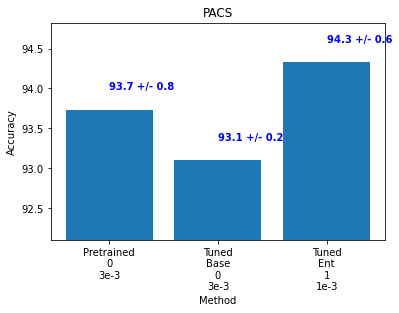

In [7]:
plot_result(result_dict, 'PACS', plot_y='acc_tgt')

## VLCS

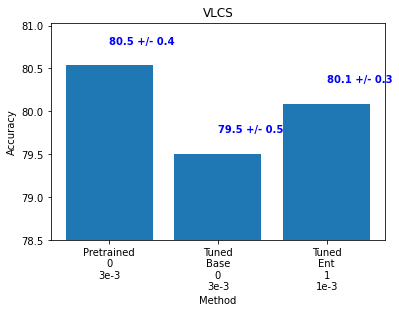

In [8]:
plot_result(result_dict, 'VLCS', plot_y='acc_tgt')

## OfficeHome

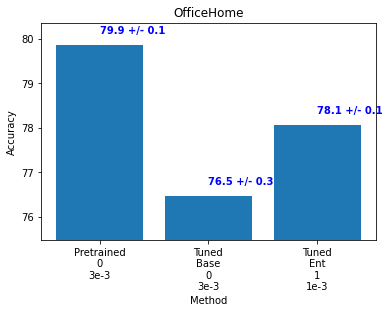

In [9]:
plot_result(result_dict, 'OfficeHome', plot_y='acc_tgt')

## TerraIncognita

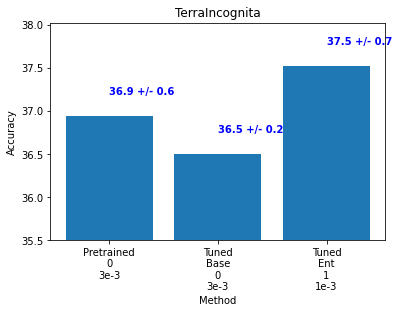

In [10]:
plot_result(result_dict, 'TerraIncognita', plot_y='acc_tgt')

# DomainNet

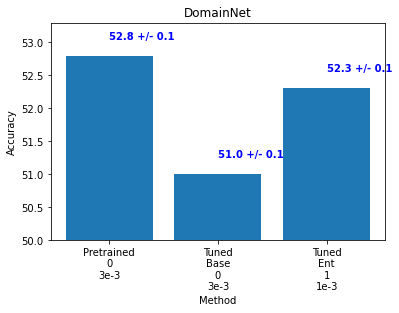

In [11]:
plot_result(result_dict, 'DomainNet', plot_y='acc_tgt')